<a href="https://colab.research.google.com/github/pnabilah/SBP_2025/blob/main/SA_SystemIden_withpytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraries

In [ ]:
# Preprocessing Imports
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
# Model Imports
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
print(torch.cuda.is_available())       # Should be True
print(torch.cuda.get_device_name(0))   # Name of the GPU (e.g., Tesla T4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# System Identification

## Phase 1

### Generate data

In [ ]:
# Generate input - output data

def generate_xt(num_samples=10):
    x = np.random.uniform(-10, 10, num_samples) # Input random
    # x = np.random.randint(-10, 10, num_samples) # Input random

    t = np.zeros(num_samples)
    t[0] = 0
    for k in range(1, num_samples):
        t[k] = 1 / (1 + t[k-1]**2) + 0.25*x[k] - 0.3*x[k-1]

    df = pd.DataFrame({"x": x, "t": t})
    return df

df = generate_xt(30002)
print(df)
df.to_csv('/content/drive/MyDrive/Colab Notebooks/SBP, MML/xt_data.csv', index=False)

              x         t
0     -1.863293  0.000000
1     -9.466625 -0.807668
2      6.137318  4.979524
3      8.232395  0.255669
4     -4.465892 -2.647547
...         ...       ...
29997  8.256588  0.043882
29998  2.961713 -0.738470
29999  4.712496  0.936718
30000 -8.459960 -2.996099
30001 -9.390670  0.290555

[30002 rows x 2 columns]


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SBP, MML/xt_data.csv')
print(df)

              x         t
0     -1.863293  0.000000
1     -9.466625 -0.807668
2      6.137318  4.979524
3      8.232395  0.255669
4     -4.465892 -2.647547
...         ...       ...
29997  8.256588  0.043882
29998  2.961713 -0.738470
29999  4.712496  0.936718
30000 -8.459960 -2.996099
30001 -9.390670  0.290555

[30002 rows x 2 columns]


### Data Preprocessing

In [ ]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t-1)" : df["t"].shift(1),
    "t(t-2)" : df["t"].shift(2),
    "t(t)"   : df["t"]
})

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

# Separate input and output
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)", "t(t-1)", "t(t-2)"]].values   # input size=6
T = df_lagged[["t(t)"]].values    # target

# check size input and output
print(X.shape, T.shape)

       x(t)    x(t-1)    x(t-2)    t(t-1)    t(t-2)      t(t)
0  6.137318 -9.466625 -1.863293 -0.807668  0.000000  4.979524
1  8.232395  6.137318 -9.466625  4.979524 -0.807668  0.255669
2 -4.465892  8.232395  6.137318  0.255669  4.979524 -2.647547
3 -4.135386 -4.465892  8.232395 -2.647547  0.255669  0.430773
4 -6.963407 -4.135386 -4.465892  0.430773 -2.647547  0.343244
(30000, 6)
(30000, 5) (30000, 1)


In [ ]:
def split_dataset_seq(X, T):
    """
    Membagi dataset 30.000 sample secara berurutan:
    - Train: 15.000 pertama
    - Val: 5.000 terakhir dari train + 5.000 setelah train
    - Test: 10.000 terakhir
    """
    X_train = X[:15000]
    T_train = T[:15000]

    X_val = np.concatenate([X[10000:15000], X[15000:20000]])
    T_val = np.concatenate([T[10000:15000], T[15000:20000]])

    X_test = X[20000:]
    T_test = T[20000:]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)


Train: (15000, 5) (15000, 1)
Val  : (10000, 5) (10000, 1)
Test : (10000, 5) (10000, 1)


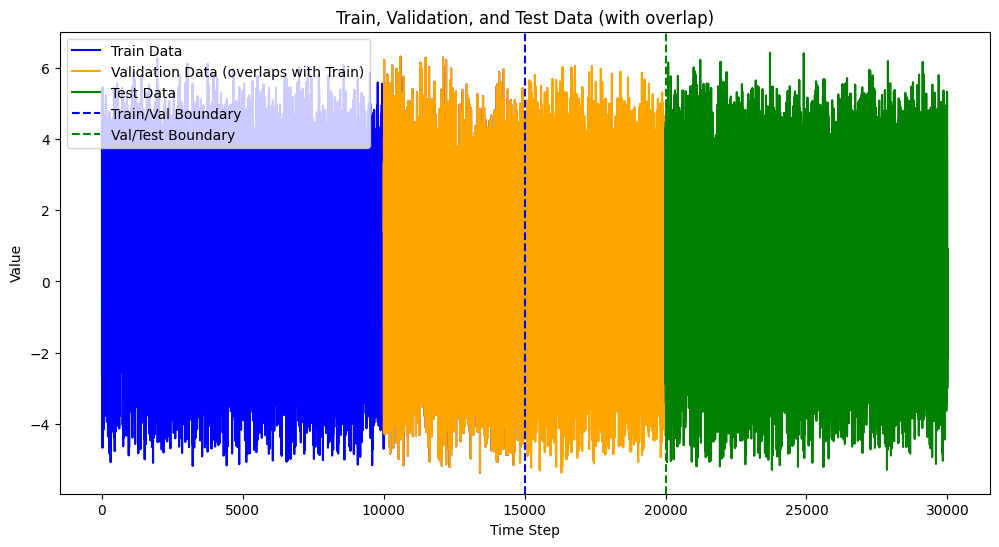

In [ ]:
plt.figure(figsize=(12, 6))

# Define your index ranges explicitly
train_start, train_end = 0, 15000
val_start, val_end = 10000, 20000
test_start = 20000
test_end = test_start + len(T_test)

# Plot each segment with its corresponding x range
plt.plot(range(train_start, train_end), T_train, label='Train Data', color='blue')
plt.plot(range(val_start, val_end), T_val, label='Validation Data (overlaps with Train)', color='orange')
plt.plot(range(test_start, test_end), T_test, label='Test Data', color='green')

# Add vertical lines to indicate approximate boundaries
plt.axvline(x=train_end, color='b', linestyle='--', label='Train/Val Boundary')
plt.axvline(x=val_end, color='g', linestyle='--', label='Val/Test Boundary')

plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Train, Validation, and Test Data (with overlap)")

plt.show()

In [ ]:
# Normalize dataset
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_train_norm = xscaler.fit_transform(X_train)
X_val_norm = xscaler.transform(X_val)
X_test_norm = xscaler.transform(X_test)

yscaler = MinMaxScaler(feature_range=(-1, 1))
T_train_norm = yscaler.fit_transform(T_train)
T_val_norm = yscaler.transform(T_val)
T_test_norm = yscaler.transform(T_test)

In [ ]:
# Prepare to be processed with GPU
# My GPU uses float32
Xtrain = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Ttrain = torch.tensor(T_train_norm, dtype=torch.float32).to(device)
Xval = torch.tensor(X_val_norm, dtype=torch.float32).to(device)
Tval = torch.tensor(T_val_norm, dtype=torch.float32).to(device)
Xtest = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Ttest = torch.tensor(T_test_norm, dtype=torch.float32).to(device)

### MLP Model

In [ ]:
input_dim = X_train.shape[1]    # 5
output_dim = T_train.shape[1]   # 1

class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, output_dim)
    self.tanh = nn.Tanh()
  def forward(self, x):
    x = self.tanh(self.fc1(x))
    x = self.tanh(self.fc2(x))
    x = self.tanh(self.fc3(x))
    x = self.fc4(x)
    return x

model = MLP(input_dim, output_dim).to(device)

### Training and Validation

In [ ]:
# training setup
n_epochs = 100
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# validation setup
patience = 10
tol = 1e-5

def train(model, optimizer, loss_fn, X_train, T_train, X_val, T_val,
          epochs=20, patience=10, tol=1e-5, device="cpu"):
    history = {"train_loss":[], "val_loss":[]}
    best_val_loss = float('inf')
    patience_ctr = 0
    for epoch in range(epochs):
        # === train ====
        model.train()
        train_loss = 0.0
        for i in range(len(X_train)):
            x = X_train[i]
            t = T_train[i]
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, t)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(X_train)
        history["train_loss"].append(train_loss)

        # === validate ===
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i in range(len(X_val)):
                x = X_val[i]
                t = T_val[i]
                pred = model(x)
                loss = loss_fn(pred, t)
                val_loss += loss.item()
        val_loss /= len(X_val)
        history["val_loss"].append(val_loss)

        # === early stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # best_model_weights = model.state_dict()  # simpan di memory
            # torch.save(model.state_dict(), 'best_model.pt')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, '/content/drive/MyDrive/Colab Notebooks/SBP, MML/SA_first_checkpoint.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        # if patience_ctr >= patience:
        #     print(f"Early stopping at epoch {epoch+1}")
        #     break

        if train_loss < tol:
            # best_model_weights = model.state_dict()  # simpan di memory
            # torch.save(model.state_dict(), 'best_model.pt')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, '/content/drive/MyDrive/Colab Notebooks/SBP, MML/SA_first_checkpoint.pt')
            break

        print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")

    return history

history = train(model, optimizer, loss_fn, Xtrain, Ttrain, Xval, Tval, n_epochs, patience, tol, device)

Epoch 0: train MSE 0.002094, val MSE 0.000540
Epoch 1: train MSE 0.000598, val MSE 0.000170
Epoch 2: train MSE 0.000363, val MSE 0.000093
Epoch 3: train MSE 0.000266, val MSE 0.000075
Epoch 4: train MSE 0.000217, val MSE 0.000052
Epoch 5: train MSE 0.000190, val MSE 0.000031
Epoch 6: train MSE 0.000174, val MSE 0.000030
Epoch 7: train MSE 0.000159, val MSE 0.000031
Epoch 8: train MSE 0.000153, val MSE 0.000022
Epoch 9: train MSE 0.000138, val MSE 0.000024
Epoch 10: train MSE 0.000141, val MSE 0.000029
Epoch 11: train MSE 0.000130, val MSE 0.000024
Epoch 12: train MSE 0.000129, val MSE 0.000020
Epoch 13: train MSE 0.000122, val MSE 0.000048
Epoch 14: train MSE 0.000111, val MSE 0.000030
Epoch 15: train MSE 0.000114, val MSE 0.000025
Epoch 16: train MSE 0.000117, val MSE 0.000032
Epoch 17: train MSE 0.000116, val MSE 0.000023
Epoch 18: train MSE 0.000111, val MSE 0.000045
Epoch 19: train MSE 0.000102, val MSE 0.000032
Epoch 20: train MSE 0.000108, val MSE 0.000022
Epoch 21: train MSE 0.0

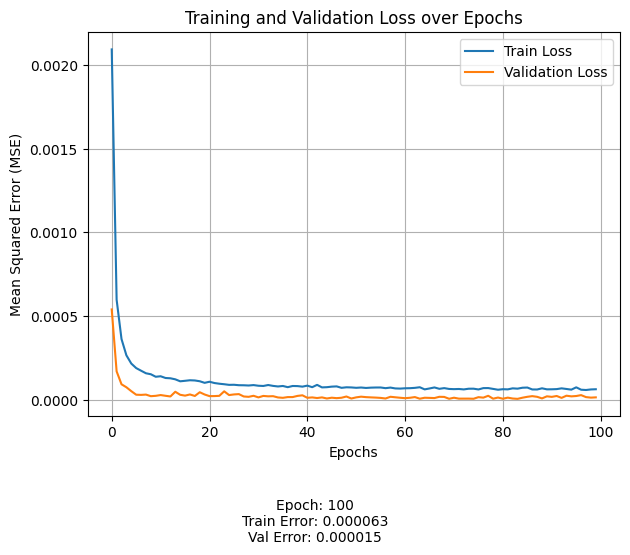

In [ ]:
# Training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/SBP, MML/SA_first_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Predictions
model.eval()
pred = []
with torch.no_grad():
  for i in range(len(Xtest)):
    x = Xtest[i]
    y_pred = model(x)
    pred.append(y_pred.cpu().numpy())

pred = np.array(pred)   # numpy, (1000, 1), scaled
pred = yscaler.inverse_transform(pred)

print(f"type: {type(pred)}, dim: {pred.shape}")
print(f"type: {type(T_test)}, dim: {T_test.shape}")

print(pred)
print(T_test)

mse_test = np.mean((pred - T_test)**2)
print(f"mse test: {mse_test}")

type: <class 'numpy.ndarray'>, dim: (10000, 1)
type: <class 'numpy.ndarray'>, dim: (10000, 1)
[[ 1.0278229 ]
 [ 2.2558267 ]
 [ 1.7597704 ]
 ...
 [ 0.94902486]
 [-2.9690988 ]
 [ 0.28859633]]
[[ 1.03331644]
 [ 2.23905557]
 [ 1.7450838 ]
 ...
 [ 0.93671759]
 [-2.99609859]
 [ 0.290555  ]]
mse test: 0.00019710984159818643


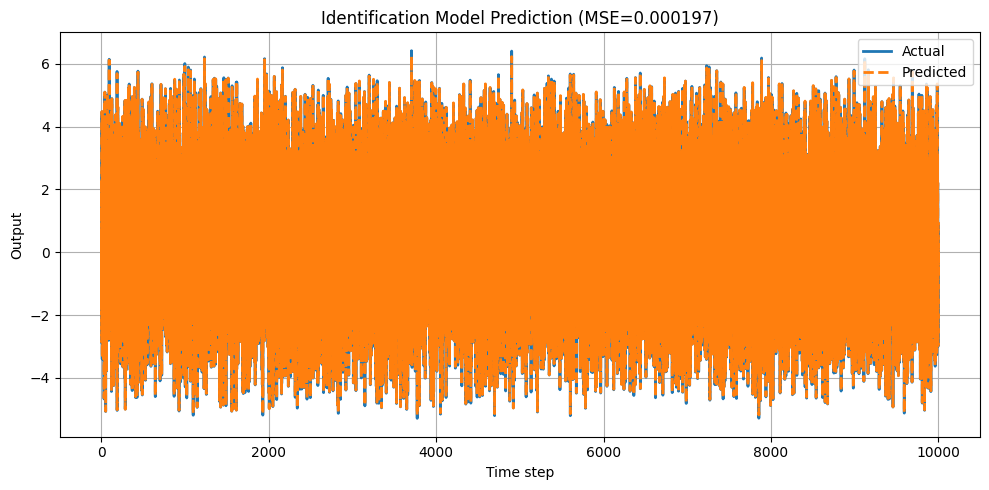

In [ ]:
# Prediction vs target plot
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(pred, label='Predicted', linestyle='--', linewidth=2)
plt.title(f'Identification Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Phase 2

### Data Preprocessing

In [ ]:
# Generate dataset with lags
df_lagged = pd.DataFrame({
    "x(t)"   : df["x"],
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "t(t)"   : df["t"]
})

df_lagged = df_lagged.dropna().reset_index(drop=True)

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       x(t)    x(t-1)    x(t-2)      t(t)
0  6.137318 -9.466625 -1.863293  4.979524
1  8.232395  6.137318 -9.466625  0.255669
2 -4.465892  8.232395  6.137318 -2.647547
3 -4.135386 -4.465892  8.232395  0.430773
4 -6.963407 -4.135386 -4.465892  0.343244
(30000, 4)


In [ ]:
# Separate input and output
X = df_lagged[["x(t)", "x(t-1)", "x(t-2)"]].values
T = df_lagged[["t(t)"]].values

# check size of dataset
print(X.shape, T.shape)

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

(30000, 3) (30000, 1)
Train: (15000, 3) (15000, 1)
Val  : (10000, 3) (10000, 1)
Test : (10000, 3) (10000, 1)


In [ ]:
# Normalize dataset
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_train_norm = xscaler.fit_transform(X_train)
X_val_norm = xscaler.transform(X_val)
X_test_norm = xscaler.transform(X_test)

yscaler = MinMaxScaler(feature_range=(-1, 1))
T_train_norm = yscaler.fit_transform(T_train)
T_val_norm = yscaler.transform(T_val)
T_test_norm = yscaler.transform(T_test)

In [ ]:
# Prepare to be processed with GPU
# My GPU uses float32
Xtrain = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Ttrain = torch.tensor(T_train_norm, dtype=torch.float32).to(device)
Xval = torch.tensor(X_val_norm, dtype=torch.float32).to(device)
Tval = torch.tensor(T_val_norm, dtype=torch.float32).to(device)
Xtest = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Ttest = torch.tensor(T_test_norm, dtype=torch.float32).to(device)

### Training and validation

In [ ]:
# narx setup
y_lags = 2
# load the same model
model = MLP(input_dim, output_dim).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
# training setup
n_epochs = 100
optimizer = optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_fn = nn.MSELoss()
# validation setup
patience = 10
tol = 1e-5

def trainNARX(model, optimizer, loss_fn, X_train, T_train, X_val, T_val, y_lags,
          epochs=20, patience=10, tol=1e-5, device="cpu"):
    history = {"train_loss":[], "val_loss":[]}
    best_val_loss = float('inf')
    patience_ctr = 0
    for epoch in range(epochs):
        # === train ====
        model.train()
        train_loss = 0.0
        y_buffer = torch.zeros(y_lags, device = device) # y_buffer = [0, 0]
        for i in range(len(X_train)):
            x = X_train[i]
            t = T_train[i]
            x_aug = torch.cat((x, y_buffer), dim=0)
            optimizer.zero_grad()
            pred = model(x_aug)
            loss = loss_fn(pred, t)
            loss.backward()
            optimizer.step()
            y_buffer = torch.cat([pred.detach(), y_buffer[1:]])
            train_loss += loss.item()
        train_loss /= len(X_train)
        history["train_loss"].append(train_loss)

        # === validate ===
        model.eval()
        val_loss = 0.0
        y_buffer = torch.zeros(y_lags, device = device) # y_buffer = [0, 0]
        with torch.no_grad():
            for i in range(len(X_val)):
                x = X_val[i]
                t = T_val[i]
                x_aug = torch.cat((x, y_buffer), dim=0)
                pred = model(x_aug)
                loss = loss_fn(pred, t)
                y_buffer = torch.cat([pred.detach(), y_buffer[1:]])
                val_loss += loss.item()
        val_loss /= len(X_val)
        history["val_loss"].append(val_loss)

        # === early stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, '/content/drive/MyDrive/Colab Notebooks/SBP, MML/SA_second_checkpoint.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        # if patience_ctr >= patience:
        #     print(f"Early stopping at epoch {epoch+1}")
        #     break

        if train_loss < tol:
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, '/content/drive/MyDrive/Colab Notebooks/SBP, MML/SA_second_checkpoint.pt')
            break

        print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")

    return history

history = trainNARX(model, optimizer, loss_fn, Xtrain, Ttrain, Xval, Tval, y_lags, n_epochs, patience, tol, device)

Epoch 0: train MSE 0.000069, val MSE 0.000016
Epoch 1: train MSE 0.000066, val MSE 0.000014
Epoch 2: train MSE 0.000077, val MSE 0.000026
Epoch 3: train MSE 0.000077, val MSE 0.000028
Epoch 4: train MSE 0.000073, val MSE 0.000016
Epoch 5: train MSE 0.000073, val MSE 0.000015
Epoch 6: train MSE 0.000072, val MSE 0.000015
Epoch 7: train MSE 0.000071, val MSE 0.000008
Epoch 8: train MSE 0.000070, val MSE 0.000041
Epoch 9: train MSE 0.000072, val MSE 0.000017
Epoch 10: train MSE 0.000071, val MSE 0.000012
Epoch 11: train MSE 0.000071, val MSE 0.000056
Epoch 12: train MSE 0.000072, val MSE 0.000018
Epoch 13: train MSE 0.000066, val MSE 0.000055
Epoch 14: train MSE 0.000062, val MSE 0.000027
Epoch 15: train MSE 0.000067, val MSE 0.000015
Epoch 16: train MSE 0.000065, val MSE 0.000044
Epoch 17: train MSE 0.000076, val MSE 0.000025
Epoch 18: train MSE 0.000071, val MSE 0.000031
Epoch 19: train MSE 0.000074, val MSE 0.000024
Epoch 20: train MSE 0.000069, val MSE 0.000019
Epoch 21: train MSE 0.0

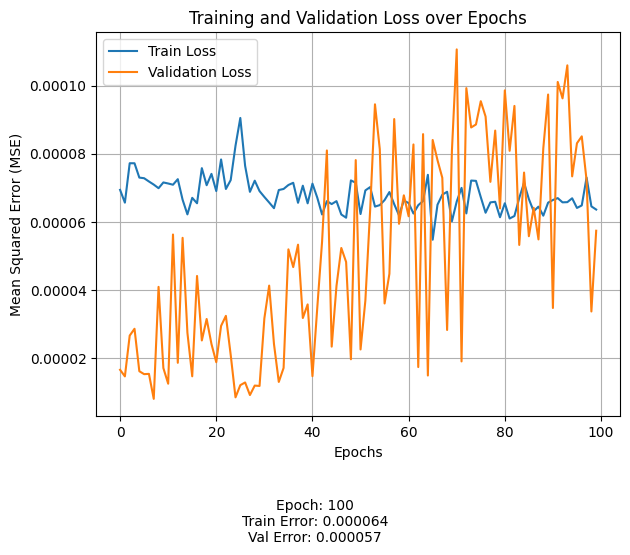

In [ ]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]
last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [ ]:
# Predictions
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/SBP, MML/SA_second_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
pred = []
y_buffer = torch.zeros(y_lags, device = device) # y_buffer = [0, 0]
with torch.no_grad():
    for i in range(len(Xtest)):
        x = Xtest[i]
        x_aug = torch.cat((x, y_buffer), dim=0)
        y_pred = model(x_aug)
        y_buffer = torch.cat([y_pred.detach(), y_buffer[1:]])
        pred.append(y_pred.cpu().numpy())

pred = np.array(pred)   # numpy, (1000, 1), scaled
pred = yscaler.inverse_transform(pred)

print(f"type: {type(pred)}, dim: {pred.shape}")
print(f"type: {type(T_test)}, dim: {T_test.shape}")

print(pred)
print(T_test)

mse_test = np.mean((pred - T_test)**2)
print(f"mse test: {mse_test}")

type: <class 'numpy.ndarray'>, dim: (10000, 1)
type: <class 'numpy.ndarray'>, dim: (10000, 1)
[[ 1.8352321 ]
 [ 2.0023787 ]
 [ 1.7917426 ]
 ...
 [ 0.9357456 ]
 [-2.968018  ]
 [ 0.28972745]]
[[ 1.03331644]
 [ 2.23905557]
 [ 1.7450838 ]
 ...
 [ 0.93671759]
 [-2.99609859]
 [ 0.290555  ]]
mse test: 0.00033941223166767515


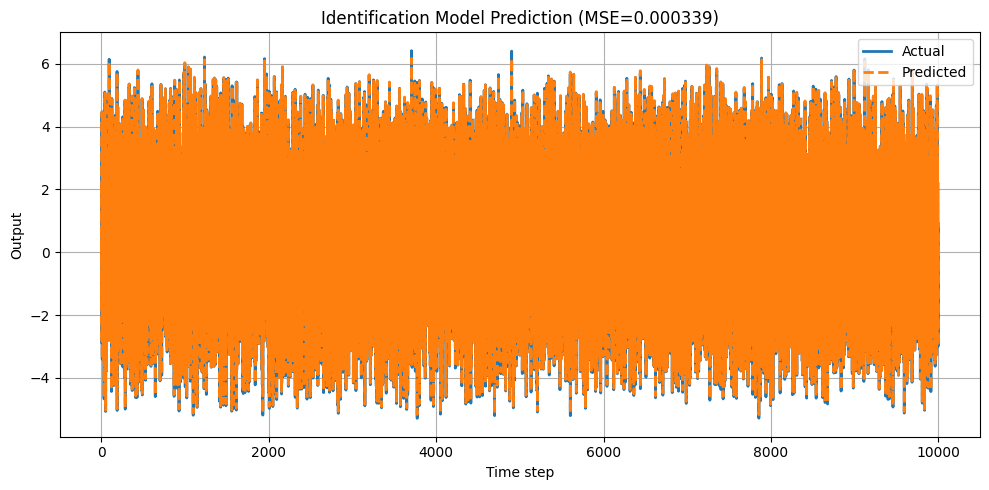

In [ ]:
# Prediction vs target plot
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(pred, label='Predicted', linestyle='--', linewidth=2)
plt.title(f'Identification Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()